# Data & Env Initialization

Before proceed this notebook, please make sure the `zip_file` and `data_path` variable in the below cell contains the path to the Sky dataset mentioned in the paper. The dataset can be downloaded at https://github.com/thienannguyen-cv/Sky-dataset. 

In [1]:
import os, sys, random, time, gc

import zipfile
from os import path
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from tqdm import tqdm # progress bar wrapping
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

zip_file = "../input/sky-dataset/Sky303.zip"
data_path = "../input/sky-dataset/Sky303/"

input_indice_path = data_path + "input_indices_{}.npy"
input_data_path = data_path + "input_data_{}.npy"
target_path = data_path + "output_indices_{}.npy"
if not path.exists(data_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(".")

# Constants

In [2]:
INF = 1e7
THETA = [0.517, -0.303, 0.] # the theta of the problem describle in the paper
N_CONFIGURATIONS = 4262 # the number of total configurations
EXPRM_N_CONFIGURATIONS = 768 # the number of configurations of the experiment
IMG_SHAPE = (2710, 3384) # size of ApolloCar3D images
H, W = 128, 256 # the window size

CAMERA = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1.]], dtype=np.float32)

# Data Viz & Utils

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

# configuration for reproducible
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print('numpy version: {}'.format(np.__version__))
print('pytorch version: {}'.format(torch.__version__))

numpy version: 1.19.5
pytorch version: 1.7.0


In [4]:
class Sky303Dataset(Dataset):
    """Car dataset."""

    def __init__(self, sample_indices=None, n_pix=0):
        super(Sky303Dataset,self).__init__()
        self.n_pix = n_pix
        self.sample_indices = sample_indices

    def __len__(self):
        if self.sample_indices is not None:
            return len(self.sample_indices)
        return N_CONFIGURATIONS

    def __getitem__(self, idx):
        if self.sample_indices is not None:
            idx = self.sample_indices[idx]
            
        # Data: Load a configuration from Sky dataset
        indice_np = np.load(input_indice_path.format(idx))
        input_np = np.load(input_data_path.format(idx))
        target_np = np.load(target_path.format(idx))
        
        input_bin_mask = np.zeros([H, W, 1], dtype='float16')
        input_bin_mask[indice_np[:,0],indice_np[:,1],:] = 1.
        
        input_2Drepr = np.zeros([H, W, 3], dtype='float16')
        input_2Drepr[indice_np[:,0],indice_np[:,1],:] = input_np
        
        target_2Drepr = np.zeros([H, W, 1], dtype='float16')
        # end Data
        
        offset_list = list(range(2*self.n_pix+1))
        # Probs: prepare a uniform distribution
        p_list = list(range(2*self.n_pix+1))
        p_sum = 0.
        for i in range(2*self.n_pix+1):
            offset_list[i] = offset_list[i]-self.n_pix
            p_list[i] = 1./(2*self.n_pix+1)
            p_sum = p_sum + p_list[i]
        p_list[-1] = 1.-(p_sum-p_list[-1])
        # end Probs
        
        # Noise: prepare screen positions of active points of new target representation
        target_np_x_offset_y_offset = np.random.choice(offset_list, size=target_np.shape, replace=True, p=p_list)
        target_np = target_np+target_np_x_offset_y_offset
        target_np_indices = np.logical_and(np.logical_and(target_np[:,0]>0,target_np[:,0]<H),np.logical_and(target_np[:,1]>0,target_np[:,1]<W))
        # end Noise
        
        target_2Drepr[target_np[target_np_indices,0],target_np[target_np_indices,1],:] = 1.
        
        input_bin_mask = np.rollaxis(input_bin_mask, 2, 0)
        input_bin_mask = torch.from_numpy(input_bin_mask).float()
        
        input_2Drepr = np.rollaxis(input_2Drepr, 2, 0)
        input_2Drepr = torch.from_numpy(input_2Drepr).float()
        
        target_2Drepr = np.rollaxis(target_2Drepr, 2, 0)
        target_2Drepr = torch.from_numpy(target_2Drepr).float()
        
        return [input_bin_mask, input_2Drepr, target_2Drepr]

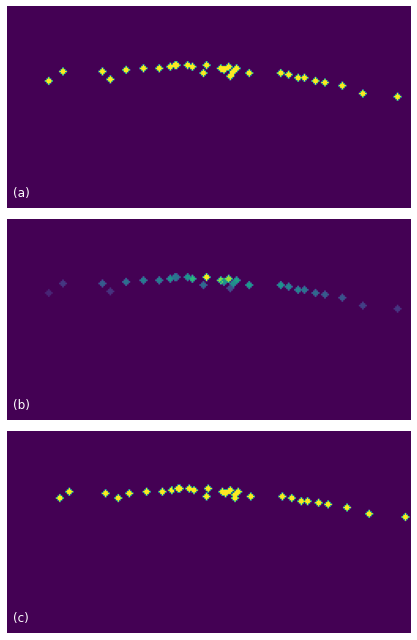

In [5]:
representative_sample_id = 1168
dataset = Sky303Dataset()

input_bin_mask, input_2Drepr, target_2Drepr = dataset[representative_sample_id]

font = {'family': 'Times New Roman',
        'color': 'white', 
        'size': 12,
        }

fig=plt.figure(figsize=(14,9))
ax1 = fig.add_subplot(3,1,1)
ax1.imshow((input_bin_mask.permute(1,2,0).numpy()[:,:,-1]).squeeze())
ax1.text(3., 120.,'(a)', fontdict=font)
plt.axis('off')

ax2 = fig.add_subplot(3,1,2)
ax2.imshow(input_2Drepr.permute(1,2,0).numpy()[:,:,-1]/350.)
ax2.text(3., 120.,'(b)', fontdict=font)
plt.axis('off')

ax3 = fig.add_subplot(3,1,3)
ax3.imshow((target_2Drepr.permute(1,2,0).numpy()[:,:,-1]).squeeze())
ax3.text(3., 120.,'(c)', fontdict=font)
plt.axis('off')

fig.tight_layout()
plt.savefig('samples.png')
plt.show()

# Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    return x[tuple(slice(None, None) if i != dim
             else torch.arange(x.size(i)-1, -1, -1).long()
             for i in range(x.dim()))]

class SDM3X3(nn.Module):
    def __init__(self, camera_matrix):
        super(SDM3X3,self).__init__()
        self.camera_matrix = nn.Parameter(torch.from_numpy(camera_matrix), requires_grad=False)
        self.camera_matrix_inv = nn.Parameter(torch.from_numpy(np.linalg.inv(camera_matrix)), requires_grad=False)

        self.sm = nn.Softmax(dim=2)
    
    def ZtoXYadjustment(self, z, height, width, panels, original_size):
        y_im, x_im = panels
        y_im, x_im = torch.from_numpy(y_im + original_size[0]).reshape(height, width), torch.from_numpy(x_im).reshape(height, width)
        y_im = y_im * IMG_SHAPE[0] / (original_size[0] * 2)
        x_im = x_im * IMG_SHAPE[1] / original_size[1]
        y_im, x_im = y_im.to(device), x_im.to(device)
        
        imp_co = torch.cat([torch.einsum('hw,bczhw->bczhw', x_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.einsum('hw,bczhw->bczhw', y_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.ones_like(z.unsqueeze(2))], 2)
        imp_co = F.unfold(imp_co.reshape(1, -1, height, width), kernel_size=(3,3), stride=(1,1), padding=(1,1), dilation=(1,1)).reshape(z.size(0),z.size(1),3,3*3,height,width)
        imp_co = torch.einsum('bchw,bczshw->bczshw', z.float(), imp_co.float()).reshape(z.size(0),z.size(1),3,3*3,-1)
        regr_co = torch.einsum('xz,yz->xy', imp_co.reshape(z.size(0),z.size(1),3,-1).permute(0,1,3,2).reshape(-1,3).float(), self.camera_matrix_inv.float())
        regr_co = regr_co.reshape(z.size(0),z.size(1),-1,3).permute(0,1,3,2).reshape(z.size(0),z.size(1),3,3*3,height*width)
        return regr_co
    
    def agg(self, x, ind=None, largest_number=0.):
        x = x + ((x>0.).float()-1.)*(-largest_number)
        
        sizes = list(x.size())
        sizes[2] = 1
        sizes[3] = 1
        
        y01 = torch.cat([(x[:,:,0,1,:,1:,:]), torch.ones_like(x[:,:,0,1,:,:1,:])*largest_number],dim=-2).reshape(*sizes)
        y21 = torch.cat([torch.ones_like(x[:,:,2,1,:,-1:,:])*largest_number, (x[:,:,2,1,:,:-1,:])],dim=-2).reshape(*sizes)
        y10 = torch.cat([(x[:,:,1,0,:,:,1:]), torch.ones_like(x[:,:,1,0,:,:,:1])*largest_number],dim=-1).reshape(*sizes)
        y12 = torch.cat([torch.ones_like(x[:,:,1,2,:,:,-1:])*largest_number, (x[:,:,1,2,:,:,:-1])],dim=-1).reshape(*sizes)
        
        y00 = torch.cat([(x[:,:,0,0,:,1:,:]), torch.ones_like(x[:,:,0,0,:,:1,:])*largest_number],dim=-2).reshape(*sizes)
        y00 = torch.cat([(y00[:,:,0,0,:,:,1:]), torch.ones_like(y00[:,:,0,0,:,:,:1])*largest_number],dim=-1).reshape(*sizes)
        
        y02 = torch.cat([(x[:,:,0,2,:,1:,:]), torch.ones_like(x[:,:,0,2,:,:1,:])*largest_number],dim=-2).reshape(*sizes)
        y02 = torch.cat([torch.ones_like(y02[:,:,0,0,:,:,-1:])*largest_number, (y02[:,:,0,0,:,:,:-1])],dim=-1).reshape(*sizes)
        
        y20 = torch.cat([torch.ones_like(x[:,:,2,0,:,-1:,:])*largest_number, (x[:,:,2,0,:,:-1,:])],dim=-2).reshape(*sizes)
        y20 = torch.cat([(y20[:,:,0,0,:,:,1:]), torch.ones_like(y20[:,:,0,0,:,:,:1])*largest_number],dim=-1).reshape(*sizes)
        
        y22 = torch.cat([torch.ones_like(x[:,:,2,2,:,-1:,:])*largest_number, (x[:,:,2,2,:,:-1,:])],dim=-2).reshape(*sizes)
        y22 = torch.cat([torch.ones_like(y22[:,:,0,0,:,:,-1:])*largest_number, (y22[:,:,0,0,:,:,:-1])],dim=-1).reshape(*sizes)
        y11 = (x[:,:,1,1,:,:,:]).reshape(*sizes)
        
        sizes[2] = 3*3
        sizes[3] = 1
        
        x = torch.cat([y00,y01,y02,y10,y11,y12,y20,y21,y22],dim=2).reshape(*sizes)

        if ind is None:
            return x
        if sizes[4] == 3:
            sizes[4] = 1
            x0 = (x[:,:,:,:,:1,:,:]).reshape(*sizes)
            x1 = (x[:,:,:,:,1:2,:,:]).reshape(*sizes)
            x2 = (x[:,:,:,:,2:,:,:]).reshape(*sizes)
            
            sizes[2] = 1
            sizes[3] = 1
            
            x0 = torch.sum(torch.where(ind,x0,torch.zeros_like(x0)),dim=2,keepdim=True)
            x1 = torch.sum(torch.where(ind,x1,torch.zeros_like(x1)),dim=2,keepdim=True)
            x2 = torch.sum(torch.where(ind,x2,torch.zeros_like(x2)),dim=2,keepdim=True)
            
            return torch.cat([x0.reshape(*sizes), x1.reshape(*sizes), x2.reshape(*sizes)], dim=4)
        
        sizes[2] = 1
        sizes[3] = 1
        return torch.sum(torch.where(ind,x,torch.zeros_like(x)),dim=2,keepdim=True).reshape(*sizes)
    
    def forward(self, x, r_mask, target_2Dr, original_size):
        shapes = x.size()
        BATCH_SIZE, height, width = shapes[0], shapes[-2], shapes[-1]

        x_z_value = torch.cat([x, r_mask], dim=2)
        
        height = height + 2**0 + 2**0
        width = width + 2**0 + 2**0
        
        x_z_value = torch.cat([torch.zeros_like(x_z_value[:,:,:,:,:(2**0)]), x_z_value, torch.zeros_like(x_z_value[:,:,:,:,:(2**0)])], dim=-1)
        x_z_value = torch.cat([torch.zeros_like(x_z_value[:,:,:,:(2**0),:]), x_z_value, torch.zeros_like(x_z_value[:,:,:,:(2**0),:])], dim=-2)

        panels = list(np.where(np.ones([height, width])))
        offset_codes = ((height-original_size[0]), (width-original_size[1]))
        panels[0] = panels[0] - (offset_codes[0]//2) + .5
        panels[1] = panels[1] - (offset_codes[1]//2) + .5

        z_values = (x_z_value[:,:,2:3,:,:]).reshape(BATCH_SIZE,-1,1,height, width).detach().clone()
        r_mask = (x_z_value[:,:,3:4,:,:]).reshape(BATCH_SIZE,-1,1,height, width)
        x_z_value = x_z_value[:,:,:3,:,:].reshape(BATCH_SIZE,-1,3,height, width)
        grouped_key = x_z_value.reshape(BATCH_SIZE,-1,3,1,height*width)

# Line 14: 
        xy_adjustment = self.ZtoXYadjustment(z_values.reshape(BATCH_SIZE,-1,height, width), height, width, panels, original_size)
        query = xy_adjustment.reshape(BATCH_SIZE,-1,3,3*3,height*width).reshape(BATCH_SIZE,-1,3,3*3,height*width).detach().clone()

        key_query = torch.sum(torch.abs(grouped_key-query),dim=2).reshape(BATCH_SIZE,-1,3*3,height, width)
        
        weights_b = torch.zeros_like(key_query)
        _, ind = torch.max(-key_query,dim=2,keepdim=True)
        ind_mask = F.one_hot(ind, num_classes=3*3).reshape(BATCH_SIZE,-1,height, width,3*3).permute(0,1,4,2,3).reshape(BATCH_SIZE,-1,3*3,height, width)
        weights_b[ind_mask>.5] = 1.
        weights_b = (weights_b*r_mask).reshape(BATCH_SIZE,-1,3,3,height, width)
        
# Line 15: 
        new_x_z_value = torch.einsum('bcsthw,bczhw->bcstzhw', weights_b.detach().clone(), x_z_value)
        new_z_values = torch.einsum('bcsthw,bczhw->bcstzhw', weights_b, z_values).detach().clone()
        
        ind = self.agg(new_z_values, largest_number=INF)
        _, ind = torch.min(ind,dim=2,keepdim=True)
        ind = F.one_hot(ind, num_classes=3*3).reshape(BATCH_SIZE,-1,1,1,height, width,3*3).permute(0,1,6,2,3,4,5).reshape(BATCH_SIZE,-1,3*3,1,1,height, width)
        ind = (ind>.5)
        
# Line 15: (apply rmin function)
        new_x_z_value = self.agg(new_x_z_value, ind=ind).reshape(-1,3,height, width)
        new_r_mask = self.agg(weights_b.reshape(BATCH_SIZE,-1,3,3,1,height, width), ind=ind).reshape(-1,1,height, width)
        weights = None
        
        if target_2Dr is not None:
            shapes = target_2Dr.size()
            BATCH_SIZE, C_zoom, h_zoom, w_zoom = shapes[0], shapes[1], shapes[-2], shapes[-1]
            
            target_2Dr, _ = torch.max(target_2Dr.reshape(BATCH_SIZE,-1,1,h_zoom, w_zoom),dim=1,keepdim=False)

# Line 16: 
            weights = weights_b.reshape(BATCH_SIZE,C_zoom,3*3,height, width)+(key_query.detach().clone()-key_query).reshape(BATCH_SIZE,C_zoom,3*3,height, width)
            weights = weights.reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)*r_mask.reshape(BATCH_SIZE,C_zoom,1,1,1,height, width)
            weights = self.agg(weights).reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)
            
            allow = torch.ones_like(weights).reshape(BATCH_SIZE,C_zoom,3*3,1,height, width)
            allow[:,:,:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)] = (weights.reshape(BATCH_SIZE,C_zoom,3*3,1,height, width)[:,:,:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)])*target_2Dr.reshape(BATCH_SIZE,1,1,1,h_zoom, w_zoom)
            allow = self.agg(flip(allow,2).reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)).reshape(BATCH_SIZE,C_zoom,3*3,1,1,height, width)
            allow = torch.max(allow,dim=2,keepdim=True)[0]
            allow = 1.-allow
            allow = torch.cat([allow, allow, allow],dim=2)
            allow = torch.cat([allow, allow, allow],dim=3).reshape(BATCH_SIZE,C_zoom,3,3,1,height, width)
            allow = (self.agg(allow).reshape(BATCH_SIZE,-1,height, width)[:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)]).reshape(BATCH_SIZE,-1,h_zoom, w_zoom)
            
            new_x_z_value = None
            weights = (weights.reshape(BATCH_SIZE,-1,height, width)[:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)]).reshape(BATCH_SIZE,-1,h_zoom, w_zoom)
            new_r_mask = (new_r_mask[:,:,((height-h_zoom)//2):((height+h_zoom)//2),((width-w_zoom)//2):((width+w_zoom)//2)]).reshape(BATCH_SIZE,-1,h_zoom, w_zoom)

# Line 31 & 32: 
            weights = weights.detach().clone() + (weights-weights.detach().clone())*allow.detach().clone()*target_2Dr.reshape(BATCH_SIZE,1,h_zoom, w_zoom)
            
# Line 19: 
        return new_x_z_value, new_r_mask, weights

class SDM(nn.Module):
    def __init__(self, n, camera_matrix):
        super(SDM,self).__init__()
        self.n = n
        self.smap3x3 = SDM3X3(camera_matrix)
    
    def forward(self, x, r_mask, target_2Dr=None, zoom=0):
        shapes = x.size()
        BATCH_SIZE, height, width = shapes[0], shapes[2], shapes[3]
        C_zoom = 2**(self.n+self.n)
        C_zoom_2 = 2**self.n
        height_zoom = height // (2**self.n)
        width_zoom = width // (2**self.n)

# Line 21: 
        x = x.reshape(BATCH_SIZE,3,height_zoom,C_zoom_2, width_zoom,C_zoom_2).permute(0,3,5,1,2,4).reshape(BATCH_SIZE,C_zoom,3,height_zoom, width_zoom)
        r_mask = r_mask.detach().clone().reshape(BATCH_SIZE,1,height_zoom,C_zoom_2, width_zoom,C_zoom_2).permute(0,3,5,1,2,4).reshape(BATCH_SIZE,C_zoom,1,height_zoom, width_zoom)
        target = None
        if target_2Dr is not None:
            target_2Dr = target_2Dr.reshape(-1,1,height_zoom,C_zoom_2, width_zoom,C_zoom_2).permute(0,3,5,1,2,4).reshape(-1,C_zoom,1,height_zoom, width_zoom)
            if self.n==zoom:
                target = target_2Dr.reshape(-1,C_zoom,height_zoom, width_zoom)
                
# Line 25: 
        x, r_mask, weights = self.smap3x3(x, r_mask, target, (height_zoom, width_zoom))
        _, _, h_out, w_out = r_mask.size()
        
        for i in range(self.n-zoom):
            C_zoom = C_zoom//4
            C_zoom_2 = C_zoom_2//2
            height_zoom = height_zoom*2
            width_zoom = width_zoom*2
            h_out = h_out*2
            w_out = w_out*2
            
# Line 28: 
            x = x.reshape(-1,2,C_zoom_2,2,C_zoom_2,3,h_out//2, w_out//2).permute(0,2,4,5,6,1,7,3).reshape(-1,C_zoom,3,h_out, w_out)
            r_mask = r_mask.reshape(-1,2,C_zoom_2,2,C_zoom_2,1,h_out//2, w_out//2).permute(0,2,4,5,6,1,7,3).reshape(-1,C_zoom,1,h_out, w_out)
            if target_2Dr is not None:
                target_2Dr = target_2Dr.reshape(-1,2,C_zoom_2,2,C_zoom_2,1,height_zoom//2, width_zoom//2).permute(0,2,4,5,6,1,7,3).reshape(-1,C_zoom,height_zoom, width_zoom)
                if i==(self.n-zoom-1):
                    target = target_2Dr.reshape(-1,C_zoom,height_zoom, width_zoom)
# Line 29: 
            x, r_mask, weights = self.smap3x3(x, r_mask, target, (height_zoom, width_zoom))
            _, _, h_out, w_out = r_mask.size()
        
        return weights

class Model(nn.Module):
    def __init__(self, camera_matrix, n=0):
        super(Model,self).__init__()
        self.n = n
        self.theta = nn.Parameter(torch.from_numpy(np.array([0.,-0.])).float().reshape(1,2,1,1), requires_grad=True)
        self.smap_layer = SDM(n, camera_matrix)
        
    def forward(self, x, r_mask, target_2Dr=None, zoom=0):
        x = x+r_mask*torch.cat([self.theta, torch.zeros_like(self.theta[:,:1,:,:])], dim=1)

        weights = self.smap_layer(x, r_mask, target_2Dr, zoom)

        return weights

# Sky Dataset

In [8]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler, SubsetRandomSampler

In [9]:
train_valid_indices, _= train_test_split(np.arange(N_CONFIGURATIONS), train_size=768, random_state=0, shuffle=True)
train_indices, valid_indices= train_test_split(train_valid_indices, train_size=512, random_state=0, shuffle=True)
train_sampler = SubsetRandomSampler(np.arange(512))
valid_sampler = SequentialSampler(np.arange(EXPRM_N_CONFIGURATIONS-512))

train_set = Sky303Dataset(train_indices) # train set
dev_set = Sky303Dataset(valid_indices) # dev set

# Hyperparameter Tuning

In [10]:
def l1_error(pred, target):
    shapes = target.size()
    m_batch_size, height, width = shapes[0], shapes[-2], shapes[-1]
    
    pred = pred.reshape(m_batch_size, -1, height*width)
    pred_m, _ = torch.max(pred.reshape(m_batch_size, -1, height*width),dim=1,keepdim=True)
    target = target.reshape(m_batch_size, 1, -1)
    target_m = target.reshape(m_batch_size, 1, -1)
    
    loss = torch.abs(pred-target)
    loss_m = torch.abs(pred_m-target_m)*pred_m
    
    loss = loss.reshape(m_batch_size, -1).sum(dim=1)
    loss_m = loss_m.reshape(m_batch_size, -1).sum(dim=1)
    
    loss = torch.mean(loss_m).detach().clone()+(loss-loss.detach().clone()).sum()
    return loss

def train_loop_fn(model, optimizer, loader, zoom, epoch, history=None):
    model.train()
    loss_np = 0.
    count = 0.
    
    for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
        m_batchsize = r_mask_batch.size(0)
        if m_batchsize != batch_size:
            break
        else:
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

        optimizer.zero_grad()
        
        weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch, zoom)
        
        target_2Dr = target_2Dr_batch.reshape(m_batchsize,1,H//(2**zoom),(2**zoom),W//(2**zoom),(2**zoom)).permute(0,3,5,1,2,4).reshape(m_batchsize,(2**(zoom+zoom)),1,H//(2**zoom),W//(2**zoom))
        target_2Dr, _ = torch.max(target_2Dr,dim=1,keepdim=False)
        
        loss = l1_error(weights, target_2Dr)

        loss.backward()
        optimizer.step()

        loss_np += loss.detach().cpu().numpy()
        count = count+1.
        
        if history is not None:
            history.loc[(zoom, epoch, batch_idx), 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
            history.loc[(zoom, epoch, batch_idx), 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
            history.loc[(zoom, epoch, batch_idx), 'loss'] = loss.detach().cpu().numpy()
    loss_np /= count
    print('Train Epoch: ({}, {}) \tLR: {:.6f}\tLoss: {:.6f}'.format(
            zoom, epoch,
            optimizer.state_dict()['param_groups'][0]['lr'],
            loss_np))
    
def evaluate_model(model, loader, key, history=None):
    model.eval()
    loss_np = 0.
    count = 0.

    with torch.no_grad():
        for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
            m_batchsize = r_mask_batch.size(0)
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

            weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch)
            
            l1 = l1_error(weights, target_2Dr_batch)
            loss_np += l1.detach().cpu().numpy()
            count = count+1.
    loss_np /= count
    if history is not None:
        history.loc[key, 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
        history.loc[key, 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
        history.loc[key, 'dev_loss'] = loss_np
    print("n_epochs: {} - lr: {}".format(*key))
    print('theta_x: {:.4f}'.format((model.theta[0,0,0,0]).detach().cpu().numpy()))
    print('theta_y: {:.4f}'.format((model.theta[0,1,0,0]).detach().cpu().numpy()))
    print('Dev loss: {:.4f}'.format(loss_np))
    
    return loss_np

In [11]:
n_epochs_list = [1,2]
lr_list = [1e-4,3e-4,1e-3]
batch_size = 16
n = 4
optimizer = None
model = None
best_loss = -1.


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=0, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(dev_set, batch_size=1, num_workers=0, sampler=valid_sampler)

dev_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['epoch', 'lr']), columns=['theta_x', 'theta_y', 'dev_loss'])

torch.cuda.empty_cache()
gc.collect()

for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        n_epochs = n_epochs_list[i_epoch]
        lr = lr_list[i_lr]
        train_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['zoom', 'epoch', 'batch_id']), columns=['theta_x', 'theta_y', 'loss'])

        model = Model(CAMERA, n)
        model = model.to(device)

        torch.cuda.empty_cache()

        gc.collect()
        optimizer = optim.SGD(list(model.parameters()), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs, gamma=.5)

        torch.cuda.empty_cache()
        gc.collect()

        for i in range(n+1):
            for epoch in range(n_epochs):
                zoom = n-i
                torch.cuda.empty_cache()
                gc.collect()

                loader = train_loader
                train_loop_fn(model, optimizer, loader, zoom, epoch, train_history)
                scheduler.step()

        loader = dev_loader
        start = time.time()*1000.0
        loss = evaluate_model(model, loader, (n_epochs, lr), dev_history)
        t_interval = time.time()*1000.0 - start
        print("Speed: {} ms/sample".format(t_interval/(len(dev_loader)*batch_size)))

        gc.collect()
        
        train_history.to_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        
        if best_loss < 0 or best_loss > loss:
            torch.save(model.state_dict(), "./model_best.pth".format(i_epoch, i_lr))
            best_loss = loss
        
        del model
        model = None
        del optimizer
        optimizer = None
        del scheduler
        scheduler = None
        gc.collect()

dev_history.to_csv('dev_history.csv')

  3%|▎         | 1/32 [00:00<00:04,  6.23it/s]

Train Epoch: (4, 0) 	LR: 0.000100	Loss: 1.201172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000050	Loss: 2.123047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000025	Loss: 4.179688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000013	Loss: 7.535156


  1%|          | 2/256 [00:00<00:14, 17.24it/s]

Train Epoch: (0, 0) 	LR: 0.000006	Loss: 11.123047


100%|██████████| 256/256 [00:13<00:00, 18.51it/s]


n_epochs: 1 - lr: 0.0001
theta_x: 0.4976
theta_y: -0.3073
Dev loss: 6.7031
Speed: 3.379454553127289 ms/sample


  3%|▎         | 1/32 [00:00<00:05,  5.83it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.404297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.187500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.894531


  1%|          | 3/256 [00:00<00:11, 22.64it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.242188


100%|██████████| 256/256 [00:11<00:00, 22.23it/s]


n_epochs: 1 - lr: 0.0003
theta_x: 0.5167
theta_y: -0.3030
Dev loss: 0.9297
Speed: 2.813895523548126 ms/sample


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.001000	Loss: 0.462891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000500	Loss: 0.380859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000250	Loss: 0.250000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000125	Loss: 0.304688


  1%|          | 3/256 [00:00<00:11, 22.36it/s]

Train Epoch: (0, 0) 	LR: 0.000063	Loss: 1.162109


100%|██████████| 256/256 [00:12<00:00, 20.97it/s]


n_epochs: 1 - lr: 0.001
theta_x: 0.5178
theta_y: -0.3032
Dev loss: 1.0039
Speed: 2.981686532497406 ms/sample


  6%|▋         | 2/32 [00:00<00:02, 10.16it/s]

Train Epoch: (4, 0) 	LR: 0.000100	Loss: 1.255859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 1) 	LR: 0.000100	Loss: 0.720703


100%|██████████| 32/32 [00:04<00:00,  6.40it/s]


Train Epoch: (3, 0) 	LR: 0.000050	Loss: 1.914062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 1) 	LR: 0.000050	Loss: 1.511719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000025	Loss: 3.412109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 1) 	LR: 0.000025	Loss: 2.634766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000013	Loss: 4.970703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 1) 	LR: 0.000013	Loss: 2.476562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000006	Loss: 3.958984


  1%|          | 3/256 [00:00<00:11, 21.74it/s]

Train Epoch: (0, 1) 	LR: 0.000006	Loss: 1.869141


100%|██████████| 256/256 [00:11<00:00, 22.04it/s]


n_epochs: 2 - lr: 0.0001
theta_x: 0.5147
theta_y: -0.3039
Dev loss: 1.3555
Speed: 2.837802767753601 ms/sample


  6%|▋         | 2/32 [00:00<00:02, 10.89it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 1) 	LR: 0.000300	Loss: 0.482422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.037109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 1) 	LR: 0.000150	Loss: 0.785156


100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.544922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 1) 	LR: 0.000075	Loss: 0.701172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 0.787109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 1) 	LR: 0.000037	Loss: 0.296875


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.000000


  1%|          | 3/256 [00:00<00:12, 21.04it/s]

Train Epoch: (0, 1) 	LR: 0.000019	Loss: 1.025391


100%|██████████| 256/256 [00:11<00:00, 21.48it/s]


n_epochs: 2 - lr: 0.0003
theta_x: 0.5165
theta_y: -0.3030
Dev loss: 0.9570
Speed: 2.9119240045547485 ms/sample


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.001000	Loss: 0.488281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 1) 	LR: 0.001000	Loss: 0.142578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000500	Loss: 0.222656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 1) 	LR: 0.000500	Loss: 0.144531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000250	Loss: 0.111328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 1) 	LR: 0.000250	Loss: 0.072266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000125	Loss: 0.292969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 1) 	LR: 0.000125	Loss: 0.267578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000063	Loss: 1.015625


  1%|          | 2/256 [00:00<00:15, 16.27it/s]

Train Epoch: (0, 1) 	LR: 0.000063	Loss: 0.964844


100%|██████████| 256/256 [00:11<00:00, 22.22it/s]


n_epochs: 2 - lr: 0.001
theta_x: 0.5181
theta_y: -0.3019
Dev loss: 1.2266
Speed: 2.814391791820526 ms/sample


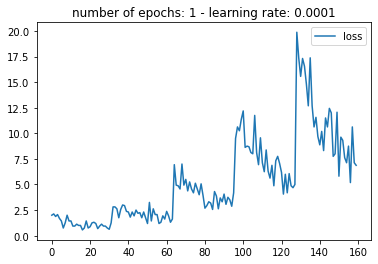

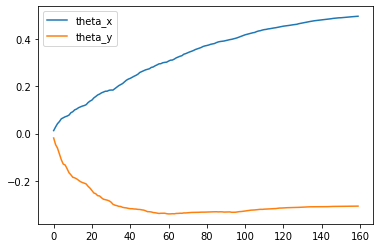

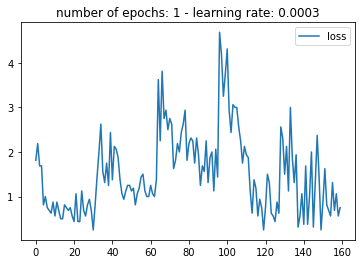

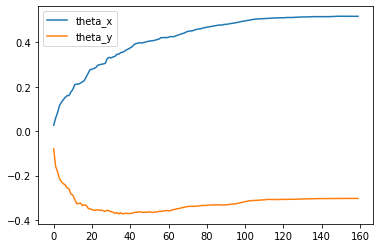

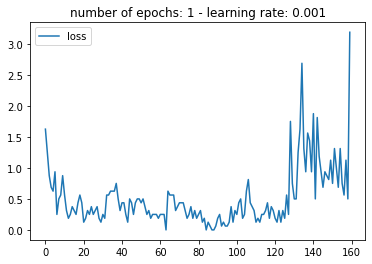

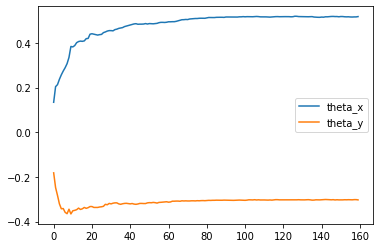

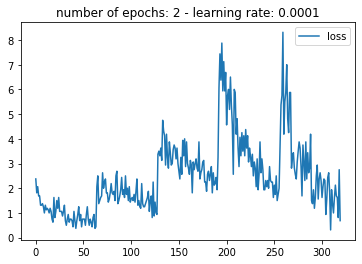

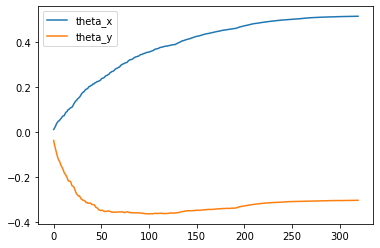

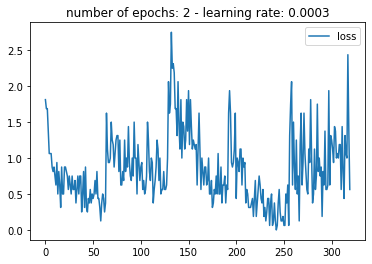

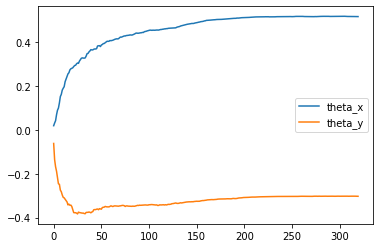

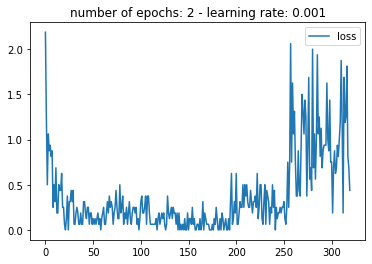

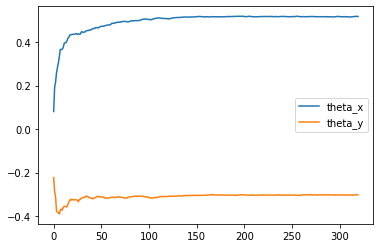

In [12]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot(title="number of epochs: {} - learning rate: {}".format(n_epochs_list[i_epoch], lr_list[i_lr]));
        train_history[['theta_x', 'theta_y']].plot();

# Table I's Data 

In [13]:
dev_history

theta_x      theta_y  dev_loss
epoch lr                                       
1     0.0001  0.49763763   -0.3073375   6.70312
      0.0003  0.51665616  -0.30301875  0.929688
      0.0010  0.51781243  -0.30318755   1.00391
2     0.0001   0.5146874   -0.3039437   1.35547
      0.0003  0.51648736  -0.30303782  0.957031
      0.0010   0.5180625  -0.30193725   1.22656

# Evaluation

In [14]:
n_pix_list = [0,1,2,3,4]

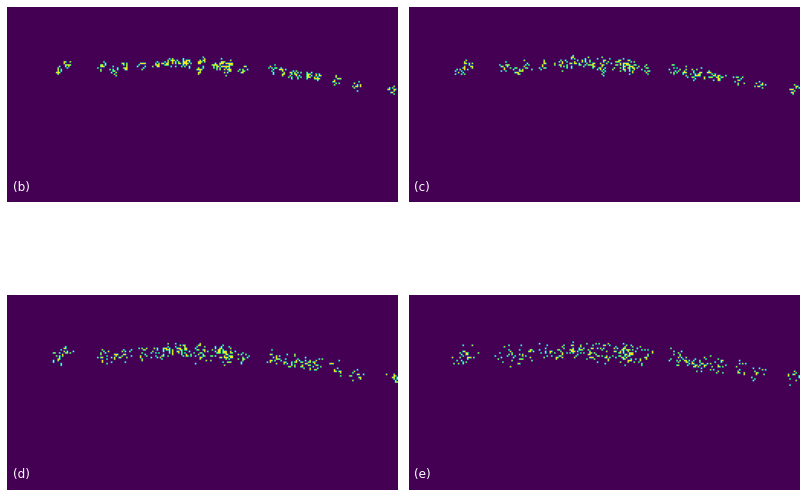

In [15]:
n_pix = 0
dataset.n_pix = n_pix

fig=plt.figure(figsize=(11.3,9.35))
texts = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i_n_pix in range(1,len(n_pix_list)):
    n_pix = n_pix_list[i_n_pix]
    dataset.n_pix=n_pix
    
    input_bin_mask, input_2Drepr, target_2Drepr = dataset[representative_sample_id]
    
    ax1 = fig.add_subplot(2,2,i_n_pix)
    plt.imshow((target_2Drepr.permute(1,2,0).numpy()[:,:,-1]).squeeze())
    ax1.text(3., 120.,texts[i_n_pix], fontdict=font)
    plt.axis('off')
    
fig.tight_layout()
plt.savefig('noise_samples.png')
plt.show()

In [16]:
test_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['n_pix', 'i-th']), columns=['theta_x', 'theta_y'])

best_n_epoch, best_lr = dev_history.index[(dev_history.reset_index().reset_index()['dev_loss']).astype(float).argmin()]
print("Best number of epoch: {} - Best learning rate: {} - Best loss: {}".format(best_n_epoch, best_lr, best_loss))
for i_n_pix in range(len(n_pix_list)):
    n_pix = n_pix_list[i_n_pix]
    train_set.n_pix=n_pix
    for ith in range(60):
        model = Model(CAMERA, n)
        model = model.to(device)

        torch.cuda.empty_cache()

        gc.collect()
        optimizer = optim.SGD(list(model.parameters()), lr=best_lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=best_n_epoch, gamma=.5)

        torch.cuda.empty_cache()
        gc.collect()

        for i in range(n+1):
            for epoch in range(best_n_epoch):
                zoom = n-i
                torch.cuda.empty_cache()
                gc.collect()

                loader = train_loader
                train_loop_fn(model, optimizer, loader, zoom, epoch)
                scheduler.step()
                
        gc.collect()

        test_history.loc[(n_pix, ith), 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
        test_history.loc[(n_pix, ith), 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
        print("n_pix: {} - ith: {}".format(n_pix, ith))
        print('theta_x: {:.4f}'.format((model.theta[0,0,0,0]).detach().cpu().numpy()))
        print('theta_y: {:.4f}'.format((model.theta[0,1,0,0]).detach().cpu().numpy()))
        
        del model
        model = None
        del optimizer
        optimizer = None
        del scheduler
        scheduler = None
        gc.collect()

test_history.to_csv('test_history.csv')

Best number of epoch: 1 - Best learning rate: 0.0003 - Best loss: 0.9296875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.876953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.250000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.193359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.041016


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.253906
n_pix: 0 - ith: 0
theta_x: 0.5161
theta_y: -0.3027


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.857422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.302734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.306641


100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.087891


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.263672
n_pix: 0 - ith: 1
theta_x: 0.5168
theta_y: -0.3030


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.884766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.404297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.316406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.082031


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.369141
n_pix: 0 - ith: 2
theta_x: 0.5168
theta_y: -0.3024


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.927734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.449219


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.312500


100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.214844


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.416016
n_pix: 0 - ith: 3
theta_x: 0.5156
theta_y: -0.3028


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.919922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.470703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.230469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.007812


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.375000
n_pix: 0 - ith: 4
theta_x: 0.5167
theta_y: -0.3028


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.914062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.378906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.343750


100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.058594


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.332031
n_pix: 0 - ith: 5
theta_x: 0.5169
theta_y: -0.3030


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.869141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.347656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.248047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.050781


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.320312
n_pix: 0 - ith: 6
theta_x: 0.5159
theta_y: -0.3027


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.886719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.308594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.242188


100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.054688


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.314453
n_pix: 0 - ith: 7
theta_x: 0.5167
theta_y: -0.3030


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.919922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.248047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.146484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.884766


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.375000
n_pix: 0 - ith: 8
theta_x: 0.5167
theta_y: -0.3030


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.865234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.380859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.332031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.009766


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.392578
n_pix: 0 - ith: 9
theta_x: 0.5161
theta_y: -0.3025


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.892578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.361328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.308594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.199219


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.292969
n_pix: 0 - ith: 10
theta_x: 0.5167
theta_y: -0.3023


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.400391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.234375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.058594


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.375000
n_pix: 0 - ith: 11
theta_x: 0.5161
theta_y: -0.3030


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.871094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.496094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.248047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.166016


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.199219
n_pix: 0 - ith: 12
theta_x: 0.5168
theta_y: -0.3026


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.859375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.308594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.253906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.988281


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.398438
n_pix: 0 - ith: 13
theta_x: 0.5169
theta_y: -0.3034


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.876953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.386719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.320312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.058594


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.287109
n_pix: 0 - ith: 14
theta_x: 0.5164
theta_y: -0.3025


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.826172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.363281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.242188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.986328


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.197266
n_pix: 0 - ith: 15
theta_x: 0.5161
theta_y: -0.3027


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.818359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.283203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.343750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.861328


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.361328
n_pix: 0 - ith: 16
theta_x: 0.5162
theta_y: -0.3030


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.875000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.345703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.294922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.949219


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.328125
n_pix: 0 - ith: 17
theta_x: 0.5166
theta_y: -0.3024


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.857422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.433594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.365234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.158203


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.474609
n_pix: 0 - ith: 18
theta_x: 0.5167
theta_y: -0.3031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.773438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.347656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.271484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.005859


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.291016
n_pix: 0 - ith: 19
theta_x: 0.5162
theta_y: -0.3023


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.853516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.533203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.302734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.000000


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.240234
n_pix: 0 - ith: 20
theta_x: 0.5166
theta_y: -0.3024


  3%|▎         | 1/32 [00:00<00:04,  6.75it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.902344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.333984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.306641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.095703


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.298828
n_pix: 0 - ith: 21
theta_x: 0.5164
theta_y: -0.3028


  3%|▎         | 1/32 [00:00<00:04,  6.81it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.830078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.275391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.283203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.992188


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.269531
n_pix: 0 - ith: 22
theta_x: 0.5168
theta_y: -0.3030


  3%|▎         | 1/32 [00:00<00:04,  6.72it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.882812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.470703


100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.378906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.191406


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.218750
n_pix: 0 - ith: 23
theta_x: 0.5166
theta_y: -0.3028


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.789062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.408203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.265625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.101562


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.341797
n_pix: 0 - ith: 24
theta_x: 0.5163
theta_y: -0.3031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.300781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.146484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.837891


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.400391
n_pix: 0 - ith: 25
theta_x: 0.5163
theta_y: -0.3027


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.859375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.419922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.353516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.033203


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.386719
n_pix: 0 - ith: 26
theta_x: 0.5165
theta_y: -0.3031


  3%|▎         | 1/32 [00:00<00:05,  6.01it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.876953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.341797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.363281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.279297


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.351562
n_pix: 0 - ith: 27
theta_x: 0.5162
theta_y: -0.3029


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.855469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.345703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.291016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.183594


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.363281
n_pix: 0 - ith: 28
theta_x: 0.5171
theta_y: -0.3029


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.794922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.291016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.269531


100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.138672


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.404297
n_pix: 0 - ith: 29
theta_x: 0.5154
theta_y: -0.3029


  3%|▎         | 1/32 [00:00<00:05,  5.61it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.880859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.373047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.357422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.972656


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.242188
n_pix: 0 - ith: 30
theta_x: 0.5166
theta_y: -0.3029


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.822266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.388672


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.240234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.052734


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.376953
n_pix: 0 - ith: 31
theta_x: 0.5166
theta_y: -0.3024


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.902344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.478516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.289062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.099609


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.216797
n_pix: 0 - ith: 32
theta_x: 0.5161
theta_y: -0.3029


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.914062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.423828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.304688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.103516


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.207031
n_pix: 0 - ith: 33
theta_x: 0.5162
theta_y: -0.3023


  3%|▎         | 1/32 [00:00<00:04,  6.63it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.884766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.330078


100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.226562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.105469


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.355469
n_pix: 0 - ith: 34
theta_x: 0.5161
theta_y: -0.3021


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.878906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.367188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.308594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.095703


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.322266
n_pix: 0 - ith: 35
theta_x: 0.5161
theta_y: -0.3023


  3%|▎         | 1/32 [00:00<00:04,  6.37it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.876953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.457031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.281250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.058594


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.205078
n_pix: 0 - ith: 36
theta_x: 0.5164
theta_y: -0.3024


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.859375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.365234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.181641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.849609


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.406250
n_pix: 0 - ith: 37
theta_x: 0.5167
theta_y: -0.3031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.849609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.369141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.226562


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.935547


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.310547
n_pix: 0 - ith: 38
theta_x: 0.5167
theta_y: -0.3029


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.904297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.423828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.277344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.035156


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.292969
n_pix: 0 - ith: 39
theta_x: 0.5159
theta_y: -0.3033


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.849609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.439453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.501953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.988281


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.253906
n_pix: 0 - ith: 40
theta_x: 0.5167
theta_y: -0.3031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.900391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.324219


100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.251953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.115234


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.222656
n_pix: 0 - ith: 41
theta_x: 0.5166
theta_y: -0.3024


  3%|▎         | 1/32 [00:00<00:04,  6.81it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.847656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.328125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.166016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.115234


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.273438
n_pix: 0 - ith: 42
theta_x: 0.5160
theta_y: -0.3019


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.851562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.398438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.298828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.982422


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.353516
n_pix: 0 - ith: 43
theta_x: 0.5169
theta_y: -0.3026


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.792969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.380859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.292969


100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.136719


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.365234
n_pix: 0 - ith: 44
theta_x: 0.5162
theta_y: -0.3025


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.835938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.289062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.115234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.046875


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.255859
n_pix: 0 - ith: 45
theta_x: 0.5165
theta_y: -0.3026


  3%|▎         | 1/32 [00:00<00:04,  6.73it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.880859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.363281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.314453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.947266


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.283203
n_pix: 0 - ith: 46
theta_x: 0.5165
theta_y: -0.3026


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.919922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.375000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.339844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.109375


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.369141
n_pix: 0 - ith: 47
theta_x: 0.5164
theta_y: -0.3026


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.910156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.400391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.306641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.126953


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.382812
n_pix: 0 - ith: 48
theta_x: 0.5160
theta_y: -0.3024


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.894531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.371094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.191406


100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.019531


100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.273438
n_pix: 0 - ith: 49
theta_x: 0.5167
theta_y: -0.3030


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.873047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.386719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.242188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.101562


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.359375
n_pix: 0 - ith: 50
theta_x: 0.5161
theta_y: -0.3026


  3%|▎         | 1/32 [00:00<00:04,  6.69it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.929688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.445312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.246094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.054688


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.425781
n_pix: 0 - ith: 51
theta_x: 0.5164
theta_y: -0.3027


  3%|▎         | 1/32 [00:00<00:04,  6.54it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.830078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.289062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.191406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.875000


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.332031
n_pix: 0 - ith: 52
theta_x: 0.5166
theta_y: -0.3027


  3%|▎         | 1/32 [00:00<00:04,  6.44it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.828125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.423828


100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.261719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.099609


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.285156
n_pix: 0 - ith: 53
theta_x: 0.5168
theta_y: -0.3025


  3%|▎         | 1/32 [00:00<00:04,  6.60it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.849609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.445312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.341797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.009766


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.345703
n_pix: 0 - ith: 54
theta_x: 0.5165
theta_y: -0.3028


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.884766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.332031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.216797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 1.968750


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.445312
n_pix: 0 - ith: 55
theta_x: 0.5170
theta_y: -0.3031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.792969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.396484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.285156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.003906


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.291016
n_pix: 0 - ith: 56
theta_x: 0.5172
theta_y: -0.3034


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.839844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.408203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.300781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.003906


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.343750
n_pix: 0 - ith: 57
theta_x: 0.5165
theta_y: -0.3029


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.876953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.359375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.279297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.017578


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.238281
n_pix: 0 - ith: 58
theta_x: 0.5168
theta_y: -0.3028


  3%|▎         | 1/32 [00:00<00:04,  6.57it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.869141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.380859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.347656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 2.195312


100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 1.330078
n_pix: 0 - ith: 59
theta_x: 0.5162
theta_y: -0.3027


  3%|▎         | 1/32 [00:00<00:04,  6.55it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.849609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.333984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.068359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.253906


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.232422
n_pix: 1 - ith: 0
theta_x: 0.5206
theta_y: -0.3201


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.851562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.523438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.218750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.441406


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.410156
n_pix: 1 - ith: 1
theta_x: 0.5210
theta_y: -0.3126


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.871094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.455078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.291016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.980469


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.785156
n_pix: 1 - ith: 2
theta_x: 0.5256
theta_y: -0.3205


  3%|▎         | 1/32 [00:00<00:04,  6.62it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.806641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.341797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.015625


100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.099609


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.492188
n_pix: 1 - ith: 3
theta_x: 0.5246
theta_y: -0.3171


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.751953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.250000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.058594


100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.964844


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.285156
n_pix: 1 - ith: 4
theta_x: 0.5257
theta_y: -0.3124


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.835938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.359375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.966797


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.980469


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 71.763672
n_pix: 1 - ith: 5
theta_x: 0.5228
theta_y: -0.3157


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.859375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.427734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.298828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.146484


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.439453
n_pix: 1 - ith: 6
theta_x: 0.5178
theta_y: -0.3164


  3%|▎         | 1/32 [00:00<00:04,  6.28it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.927734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.550781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.091797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.052734


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.910156
n_pix: 1 - ith: 7
theta_x: 0.5268
theta_y: -0.3191


  3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.863281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.464844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.236328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.037109


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.310547
n_pix: 1 - ith: 8
theta_x: 0.5213
theta_y: -0.3172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.841797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.431641


100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.226562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.197266


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.308594
n_pix: 1 - ith: 9
theta_x: 0.5231
theta_y: -0.3145


  3%|▎         | 1/32 [00:00<00:04,  6.28it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.882812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.507812


100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.208984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.005859


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.677734
n_pix: 1 - ith: 10
theta_x: 0.5185
theta_y: -0.3157


  3%|▎         | 1/32 [00:00<00:04,  6.66it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.812500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.382812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.193359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.373047


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.390625
n_pix: 1 - ith: 11
theta_x: 0.5242
theta_y: -0.3155


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.861328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.361328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.931641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.798828


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 71.958984
n_pix: 1 - ith: 12
theta_x: 0.5153
theta_y: -0.3153


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.779297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.462891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.027344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.187500


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.507812
n_pix: 1 - ith: 13
theta_x: 0.5246
theta_y: -0.3186


  3%|▎         | 1/32 [00:00<00:04,  6.72it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.839844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.375000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.140625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.130859


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.669922
n_pix: 1 - ith: 14
theta_x: 0.5251
theta_y: -0.3198


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.871094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.503906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.126953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.095703


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.857422
n_pix: 1 - ith: 15
theta_x: 0.5223
theta_y: -0.3145


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.816406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.433594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.994141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.289062


100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.595703
n_pix: 1 - ith: 16
theta_x: 0.5330
theta_y: -0.3233


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.744141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.410156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.062500


100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.980469


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.363281
n_pix: 1 - ith: 17
theta_x: 0.5156
theta_y: -0.3223


  3%|▎         | 1/32 [00:00<00:04,  6.76it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.833984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.359375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.105469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.033203


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.308594
n_pix: 1 - ith: 18
theta_x: 0.5158
theta_y: -0.3154


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.849609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.414062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.107422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.064453


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.410156
n_pix: 1 - ith: 19
theta_x: 0.5179
theta_y: -0.3182


  3%|▎         | 1/32 [00:00<00:04,  6.51it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.884766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.369141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.064453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.083984


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.509766
n_pix: 1 - ith: 20
theta_x: 0.5182
theta_y: -0.3179


  3%|▎         | 1/32 [00:00<00:04,  6.61it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.816406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.455078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.187500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.935547


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.705078
n_pix: 1 - ith: 21
theta_x: 0.5244
theta_y: -0.3262


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.824219


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.560547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.156250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.320312


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.421875
n_pix: 1 - ith: 22
theta_x: 0.5233
theta_y: -0.3209


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.820312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.468750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.156250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.054688


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.355469
n_pix: 1 - ith: 23
theta_x: 0.5249
theta_y: -0.3198


  3%|▎         | 1/32 [00:00<00:04,  6.74it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.804688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.443359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.148438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.035156


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.806641
n_pix: 1 - ith: 24
theta_x: 0.5229
theta_y: -0.3161


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.853516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.330078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.169922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.185547


100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.312500
n_pix: 1 - ith: 25
theta_x: 0.5171
theta_y: -0.3146


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.828125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.486328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.003906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.990234


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.335938
n_pix: 1 - ith: 26
theta_x: 0.5234
theta_y: -0.3124


  3%|▎         | 1/32 [00:00<00:04,  6.73it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.843750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.419922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.148438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.041016


100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.802734
n_pix: 1 - ith: 27
theta_x: 0.5235
theta_y: -0.3202


  3%|▎         | 1/32 [00:00<00:04,  6.68it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.833984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.468750


100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.160156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.119141


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.150391
n_pix: 1 - ith: 28
theta_x: 0.5233
theta_y: -0.3166


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.861328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.535156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.341797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.912109


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.345703
n_pix: 1 - ith: 29
theta_x: 0.5216
theta_y: -0.3220


  3%|▎         | 1/32 [00:00<00:05,  5.76it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.923828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.511719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.095703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.994141


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.410156
n_pix: 1 - ith: 30
theta_x: 0.5228
theta_y: -0.3193


  3%|▎         | 1/32 [00:00<00:05,  6.17it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.800781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.498047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.109375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.070312


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.869141
n_pix: 1 - ith: 31
theta_x: 0.5258
theta_y: -0.3209


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.810547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.380859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.080078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.937500


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.306641
n_pix: 1 - ith: 32
theta_x: 0.5207
theta_y: -0.3158


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.873047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.476562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.199219


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.400391


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.667969
n_pix: 1 - ith: 33
theta_x: 0.5170
theta_y: -0.3204


  3%|▎         | 1/32 [00:00<00:04,  6.60it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.904297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.345703


100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.255859


100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.097656


100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.566406
n_pix: 1 - ith: 34
theta_x: 0.5230
theta_y: -0.3225


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.869141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.472656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.099609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.253906


100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.576172
n_pix: 1 - ith: 35
theta_x: 0.5209
theta_y: -0.3225


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.796875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.343750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.980469


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.189453


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.841797
n_pix: 1 - ith: 36
theta_x: 0.5225
theta_y: -0.3215


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.732422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.390625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.146484


100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.167969


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.638672
n_pix: 1 - ith: 37
theta_x: 0.5229
theta_y: -0.3143


  3%|▎         | 1/32 [00:00<00:04,  6.76it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.820312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.554688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.140625


100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.251953


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.734375
n_pix: 1 - ith: 38
theta_x: 0.5296
theta_y: -0.3203


  3%|▎         | 1/32 [00:00<00:04,  6.68it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.816406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.429688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.982422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.015625


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.550781
n_pix: 1 - ith: 39
theta_x: 0.5197
theta_y: -0.3222


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.828125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.367188


100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.259766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.289062


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.576172
n_pix: 1 - ith: 40
theta_x: 0.5162
theta_y: -0.3170


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.794922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.382812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.335938


100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.300781


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.542969
n_pix: 1 - ith: 41
theta_x: 0.5170
theta_y: -0.3167


  3%|▎         | 1/32 [00:00<00:04,  6.66it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.814453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.376953


100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.386719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.158203


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.517578
n_pix: 1 - ith: 42
theta_x: 0.5283
theta_y: -0.3233


  3%|▎         | 1/32 [00:00<00:04,  6.76it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.886719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.494141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.148438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.218750


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.312500
n_pix: 1 - ith: 43
theta_x: 0.5243
theta_y: -0.3185


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.494141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.216797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.144531


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.718750
n_pix: 1 - ith: 44
theta_x: 0.5230
theta_y: -0.3213


  3%|▎         | 1/32 [00:00<00:04,  6.56it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.839844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.341797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.078125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.390625


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.496094
n_pix: 1 - ith: 45
theta_x: 0.5141
theta_y: -0.3172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.855469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.406250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.136719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.228516


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.363281
n_pix: 1 - ith: 46
theta_x: 0.5183
theta_y: -0.3204


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.820312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.435547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.236328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.265625


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 71.929688
n_pix: 1 - ith: 47
theta_x: 0.5171
theta_y: -0.3136


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.908203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.437500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.154297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.041016


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.351562
n_pix: 1 - ith: 48
theta_x: 0.5175
theta_y: -0.3180


  3%|▎         | 1/32 [00:00<00:04,  6.83it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.484375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.376953


100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.314453


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.441406
n_pix: 1 - ith: 49
theta_x: 0.5207
theta_y: -0.3170


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.824219


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.427734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.080078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.925781


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.253906
n_pix: 1 - ith: 50
theta_x: 0.5220
theta_y: -0.3228


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.851562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.404297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.177734


100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.986328


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.488281
n_pix: 1 - ith: 51
theta_x: 0.5218
theta_y: -0.3158


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.802734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.302734


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.044922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.365234


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.136719
n_pix: 1 - ith: 52
theta_x: 0.5140
theta_y: -0.3221


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.810547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.433594


100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.216797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.929688


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.363281
n_pix: 1 - ith: 53
theta_x: 0.5178
theta_y: -0.3220


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.849609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.386719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.103516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.222656


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.505859
n_pix: 1 - ith: 54
theta_x: 0.5160
theta_y: -0.3162


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.810547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.371094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.191406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.265625


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.552734
n_pix: 1 - ith: 55
theta_x: 0.5267
theta_y: -0.3145


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.800781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.505859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.296875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.349609


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.712891
n_pix: 1 - ith: 56
theta_x: 0.5213
theta_y: -0.3224


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.820312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.451172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.158203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 9.941406


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.330078
n_pix: 1 - ith: 57
theta_x: 0.5265
theta_y: -0.3168


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.857422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.482422


100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.187500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.003906


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.576172
n_pix: 1 - ith: 58
theta_x: 0.5189
theta_y: -0.3134


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.755859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.416016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 3.201172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 10.111328


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 72.335938
n_pix: 1 - ith: 59
theta_x: 0.5204
theta_y: -0.3161


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.689453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.994141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.365234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.761719


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.546875
n_pix: 2 - ith: 0
theta_x: 0.5230
theta_y: -0.3254


  3%|▎         | 1/32 [00:00<00:04,  6.70it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.654297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.037109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.345703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.822266


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.242188
n_pix: 2 - ith: 1
theta_x: 0.5314
theta_y: -0.3240


  3%|▎         | 1/32 [00:00<00:04,  6.72it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.650391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.916016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.283203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.716797


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.650391
n_pix: 2 - ith: 2
theta_x: 0.5296
theta_y: -0.3323


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.582031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.001953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.296875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.767578


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.791016
n_pix: 2 - ith: 3
theta_x: 0.5249
theta_y: -0.3257


  3%|▎         | 1/32 [00:00<00:04,  6.25it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.626953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.048828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.310547


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.806641


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.748047
n_pix: 2 - ith: 4
theta_x: 0.5263
theta_y: -0.3216


  3%|▎         | 1/32 [00:00<00:04,  6.75it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.595703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.960938


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.318359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.935547


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.498047
n_pix: 2 - ith: 5
theta_x: 0.5275
theta_y: -0.3244


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.613281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.814453


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.259766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.712891


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.822266
n_pix: 2 - ith: 6
theta_x: 0.5254
theta_y: -0.3293


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.673828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.121094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.363281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.753906


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.371094
n_pix: 2 - ith: 7
theta_x: 0.5273
theta_y: -0.3237


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.667969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.019531


100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.337891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.435547


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.433594
n_pix: 2 - ith: 8
theta_x: 0.5210
theta_y: -0.3187


  3%|▎         | 1/32 [00:00<00:04,  6.79it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.578125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.962891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.384766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.615234


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.910156
n_pix: 2 - ith: 9
theta_x: 0.5171
theta_y: -0.3220


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.683594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.001953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.429688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.781250


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.550781
n_pix: 2 - ith: 10
theta_x: 0.5298
theta_y: -0.3242


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.687500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.962891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.207031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.652344


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.947266
n_pix: 2 - ith: 11
theta_x: 0.5329
theta_y: -0.3273


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.634766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.042969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.281250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.625000


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.328125
n_pix: 2 - ith: 12
theta_x: 0.5192
theta_y: -0.3282


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.640625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.050781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.417969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.759766


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.798828
n_pix: 2 - ith: 13
theta_x: 0.5281
theta_y: -0.3288


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.691406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.958984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.296875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.923828


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.660156
n_pix: 2 - ith: 14
theta_x: 0.5263
theta_y: -0.3231


  3%|▎         | 1/32 [00:00<00:04,  6.65it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.666016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.080078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.375000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.650391


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.078125
n_pix: 2 - ith: 15
theta_x: 0.5272
theta_y: -0.3223


  3%|▎         | 1/32 [00:00<00:04,  6.64it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.675781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.916016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.257812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.810547


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.523438
n_pix: 2 - ith: 16
theta_x: 0.5210
theta_y: -0.3326


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.644531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.939453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.289062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.609375


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.873047
n_pix: 2 - ith: 17
theta_x: 0.5320
theta_y: -0.3293


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.632812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.998047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.375000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.751953


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.634766
n_pix: 2 - ith: 18
theta_x: 0.5264
theta_y: -0.3254


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.660156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.939453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.326172


100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.806641


100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.667969
n_pix: 2 - ith: 19
theta_x: 0.5233
theta_y: -0.3228


  3%|▎         | 1/32 [00:00<00:04,  6.82it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.718750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.044922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.375000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.710938


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.294922
n_pix: 2 - ith: 20
theta_x: 0.5223
theta_y: -0.3253


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.691406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.085938


100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.390625


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.720703


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.988281
n_pix: 2 - ith: 21
theta_x: 0.5233
theta_y: -0.3329


  3%|▎         | 1/32 [00:00<00:04,  6.82it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.625000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.947266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.214844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.542969


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.976562
n_pix: 2 - ith: 22
theta_x: 0.5284
theta_y: -0.3219


  3%|▎         | 1/32 [00:00<00:04,  6.73it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.767578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.101562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.417969


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.916016


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.289062
n_pix: 2 - ith: 23
theta_x: 0.5287
theta_y: -0.3211


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.669922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.037109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.242188


100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.677734


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.267578
n_pix: 2 - ith: 24
theta_x: 0.5270
theta_y: -0.3272


  3%|▎         | 1/32 [00:00<00:04,  6.36it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.644531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.968750


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.220703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.810547


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.958984
n_pix: 2 - ith: 25
theta_x: 0.5266
theta_y: -0.3293


  3%|▎         | 1/32 [00:00<00:04,  6.80it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.664062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.009766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.251953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.650391


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 91.152344
n_pix: 2 - ith: 26
theta_x: 0.5241
theta_y: -0.3229


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.617188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.021484


100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.421875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.662109


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.576172
n_pix: 2 - ith: 27
theta_x: 0.5227
theta_y: -0.3287


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.611328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.867188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.326172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.726562


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.810547
n_pix: 2 - ith: 28
theta_x: 0.5269
theta_y: -0.3275


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.625000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.974609


100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.242188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.746094


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.373047
n_pix: 2 - ith: 29
theta_x: 0.5228
theta_y: -0.3298


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.683594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.984375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.281250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.667969


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.421875
n_pix: 2 - ith: 30
theta_x: 0.5269
theta_y: -0.3275


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.666016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.039062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.226562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.712891


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.287109
n_pix: 2 - ith: 31
theta_x: 0.5317
theta_y: -0.3289


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.636719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.083984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.367188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.560547


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.099609
n_pix: 2 - ith: 32
theta_x: 0.5258
theta_y: -0.3249


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.626953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.962891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.392578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.708984


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.708984
n_pix: 2 - ith: 33
theta_x: 0.5195
theta_y: -0.3246


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.625000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.976562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.279297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.583984


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.054688
n_pix: 2 - ith: 34
theta_x: 0.5196
theta_y: -0.3290


100%|██████████| 32/32 [00:03<00:00, 10.13it/s]


Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.611328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.048828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.291016


100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.529297


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.675781
n_pix: 2 - ith: 35
theta_x: 0.5271
theta_y: -0.3223


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.666016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.080078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.337891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.775391


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 91.261719
n_pix: 2 - ith: 36
theta_x: 0.5274
theta_y: -0.3289


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.613281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.878906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.359375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.591797


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.972656
n_pix: 2 - ith: 37
theta_x: 0.5303
theta_y: -0.3289


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.605469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.957031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.343750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.675781


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.906250
n_pix: 2 - ith: 38
theta_x: 0.5258
theta_y: -0.3249


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.660156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.992188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.361328


100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.853516


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.507812
n_pix: 2 - ith: 39
theta_x: 0.5233
theta_y: -0.3281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.646484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.019531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.365234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.630859


100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.925781
n_pix: 2 - ith: 40
theta_x: 0.5292
theta_y: -0.3232


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.736328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.044922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.177734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.785156


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.855469
n_pix: 2 - ith: 41
theta_x: 0.5221
theta_y: -0.3203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.650391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.912109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.320312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.712891


100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.630859
n_pix: 2 - ith: 42
theta_x: 0.5259
theta_y: -0.3220


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.667969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.003906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.310547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.613281


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.384766
n_pix: 2 - ith: 43
theta_x: 0.5268
theta_y: -0.3226


  3%|▎         | 1/32 [00:00<00:04,  6.80it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.591797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.986328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.320312


100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.636719


100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.810547
n_pix: 2 - ith: 44
theta_x: 0.5314
theta_y: -0.3223


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.687500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.111328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.357422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.601562


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.937500
n_pix: 2 - ith: 45
theta_x: 0.5220
theta_y: -0.3278


  3%|▎         | 1/32 [00:00<00:04,  6.85it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.679688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.027344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.341797


100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.841797


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.640625
n_pix: 2 - ith: 46
theta_x: 0.5219
theta_y: -0.3279


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.738281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.068359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.437500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.640625


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.724609
n_pix: 2 - ith: 47
theta_x: 0.5264
theta_y: -0.3260


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.617188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.923828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.363281


100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.718750


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.763672
n_pix: 2 - ith: 48
theta_x: 0.5239
theta_y: -0.3317


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.720703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.125000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.359375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.955078


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.718750
n_pix: 2 - ith: 49
theta_x: 0.5253
theta_y: -0.3299


  3%|▎         | 1/32 [00:00<00:04,  6.57it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.673828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.068359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.343750


100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.623047


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.634766
n_pix: 2 - ith: 50
theta_x: 0.5285
theta_y: -0.3307


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.617188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.001953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.408203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.500000


100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.396484
n_pix: 2 - ith: 51
theta_x: 0.5199
theta_y: -0.3276


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.679688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.085938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.355469


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.656250


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.619141
n_pix: 2 - ith: 52
theta_x: 0.5237
theta_y: -0.3296


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.703125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.060547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.343750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.548828


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.644531
n_pix: 2 - ith: 53
theta_x: 0.5289
theta_y: -0.3226


  3%|▎         | 1/32 [00:00<00:04,  6.72it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.615234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.933594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.169922


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.576172


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.162109
n_pix: 2 - ith: 54
theta_x: 0.5233
theta_y: -0.3254


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.679688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.070312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.375000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.626953


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 91.394531
n_pix: 2 - ith: 55
theta_x: 0.5336
theta_y: -0.3208


  3%|▎         | 1/32 [00:00<00:04,  6.79it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.576172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.908203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.177734


100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.855469


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.429688
n_pix: 2 - ith: 56
theta_x: 0.5212
theta_y: -0.3252


  3%|▎         | 1/32 [00:00<00:04,  6.68it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.658203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.019531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.451172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.613281


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.664062
n_pix: 2 - ith: 57
theta_x: 0.5321
theta_y: -0.3262


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.648438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.085938


100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.369141


100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.769531


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.533203
n_pix: 2 - ith: 58
theta_x: 0.5216
theta_y: -0.3314


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.646484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.005859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.390625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 14.816406


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 90.271484
n_pix: 2 - ith: 59
theta_x: 0.5216
theta_y: -0.3276


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.576172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.726562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.029297


100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.224609


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.015625
n_pix: 3 - ith: 0
theta_x: 0.5220
theta_y: -0.3290


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.525391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.800781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.099609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.027344


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.822266
n_pix: 3 - ith: 1
theta_x: 0.5428
theta_y: -0.3323


  3%|▎         | 1/32 [00:00<00:04,  6.75it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.546875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.736328


100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.140625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.001953


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.687500
n_pix: 3 - ith: 2
theta_x: 0.5236
theta_y: -0.3313


  3%|▎         | 1/32 [00:00<00:04,  6.72it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.474609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.642578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.941406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.296875


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.912109
n_pix: 3 - ith: 3
theta_x: 0.5116
theta_y: -0.3289


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.507812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.714844


100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.003906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.982422


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.857422
n_pix: 3 - ith: 4
theta_x: 0.5293
theta_y: -0.3363


  3%|▎         | 1/32 [00:00<00:04,  6.65it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.505859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.716797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.082031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.060547


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.855469
n_pix: 3 - ith: 5
theta_x: 0.5206
theta_y: -0.3345


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.494141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.697266


100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.011719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.154297


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.429688
n_pix: 3 - ith: 6
theta_x: 0.5228
theta_y: -0.3322


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.501953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.726562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.070312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.025391


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.919922
n_pix: 3 - ith: 7
theta_x: 0.5409
theta_y: -0.3407


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.519531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.707031


100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.101562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.765625


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.951172
n_pix: 3 - ith: 8
theta_x: 0.5391
theta_y: -0.3401


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.527344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.738281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.156250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.123047


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.912109
n_pix: 3 - ith: 9
theta_x: 0.5212
theta_y: -0.3358


  3%|▎         | 1/32 [00:00<00:04,  6.77it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.472656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.763672


100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.003906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.193359


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.730469
n_pix: 3 - ith: 10
theta_x: 0.5312
theta_y: -0.3291


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.541016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.753906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.007812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.998047


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.685547
n_pix: 3 - ith: 11
theta_x: 0.5319
theta_y: -0.3399


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.550781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.714844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.125000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.386719


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.839844
n_pix: 3 - ith: 12
theta_x: 0.5142
theta_y: -0.3400


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.529297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.732422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.054688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.697266


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.775391
n_pix: 3 - ith: 13
theta_x: 0.5283
theta_y: -0.3318


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.580078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.798828


100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.089844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.125000


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.820312
n_pix: 3 - ith: 14
theta_x: 0.5315
theta_y: -0.3396


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.535156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.734375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.275391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.005859


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.781250
n_pix: 3 - ith: 15
theta_x: 0.5277
theta_y: -0.3311


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.496094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.707031


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.062500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.318359


100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.789062
n_pix: 3 - ith: 16
theta_x: 0.5332
theta_y: -0.3367


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.470703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.652344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.935547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.140625


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.800781
n_pix: 3 - ith: 17
theta_x: 0.5373
theta_y: -0.3379


  3%|▎         | 1/32 [00:00<00:04,  6.70it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.517578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.689453


100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.011719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.068359


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.593750
n_pix: 3 - ith: 18
theta_x: 0.5460
theta_y: -0.3379


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.468750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.750000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.052734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.072266


100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.890625
n_pix: 3 - ith: 19
theta_x: 0.5338
theta_y: -0.3338


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.517578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.675781


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.046875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.099609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.800781
n_pix: 3 - ith: 20
theta_x: 0.5230
theta_y: -0.3303


  3%|▎         | 1/32 [00:00<00:04,  6.76it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.494141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.708984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.140625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.427734


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.865234
n_pix: 3 - ith: 21
theta_x: 0.5276
theta_y: -0.3379


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.509766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.806641


100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.009766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.193359


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.789062
n_pix: 3 - ith: 22
theta_x: 0.5288
theta_y: -0.3356


  3%|▎         | 1/32 [00:00<00:04,  6.74it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.519531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.669922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.998047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.253906


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.556641
n_pix: 3 - ith: 23
theta_x: 0.5357
theta_y: -0.3329


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.531250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.654297


100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.988281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.255859


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.921875
n_pix: 3 - ith: 24
theta_x: 0.5366
theta_y: -0.3267


  3%|▎         | 1/32 [00:00<00:04,  6.79it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.513672


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.726562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.984375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.167969


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.435547
n_pix: 3 - ith: 25
theta_x: 0.5247
theta_y: -0.3283


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.527344


100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.683594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.966797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.855469


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.730469
n_pix: 3 - ith: 26
theta_x: 0.5281
theta_y: -0.3329


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.525391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.664062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.101562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.160156


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.917969
n_pix: 3 - ith: 27
theta_x: 0.5214
theta_y: -0.3370


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.490234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.755859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.101562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.111328


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.679688
n_pix: 3 - ith: 28
theta_x: 0.5210
theta_y: -0.3298


  3%|▎         | 1/32 [00:00<00:04,  6.76it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.552734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.740234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.115234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.033203


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.798828
n_pix: 3 - ith: 29
theta_x: 0.5267
theta_y: -0.3409


  3%|▎         | 1/32 [00:00<00:05,  6.13it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.490234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.712891


100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.042969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.917969


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.837891
n_pix: 3 - ith: 30
theta_x: 0.5383
theta_y: -0.3361


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.460938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.685547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.085938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.941406


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.789062
n_pix: 3 - ith: 31
theta_x: 0.5243
theta_y: -0.3344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.490234


100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.582031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.929688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.757812


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.820312
n_pix: 3 - ith: 32
theta_x: 0.5304
theta_y: -0.3328


  3%|▎         | 1/32 [00:00<00:04,  6.83it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.519531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.634766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.052734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.201172


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.724609
n_pix: 3 - ith: 33
theta_x: 0.5317
theta_y: -0.3371


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.552734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.710938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.078125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.962891


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.148438
n_pix: 3 - ith: 34
theta_x: 0.5365
theta_y: -0.3340


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.501953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.677734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.050781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.894531


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.968750
n_pix: 3 - ith: 35
theta_x: 0.5307
theta_y: -0.3461


100%|██████████| 32/32 [00:02<00:00, 11.50it/s]


Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.496094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.691406


100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.078125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.253906


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.984375
n_pix: 3 - ith: 36
theta_x: 0.5258
theta_y: -0.3355


  3%|▎         | 1/32 [00:00<00:04,  6.68it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.552734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.779297


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.091797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.289062


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.716797
n_pix: 3 - ith: 37
theta_x: 0.5387
theta_y: -0.3340


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.498047


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.755859


100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.179688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.384766


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.171875
n_pix: 3 - ith: 38
theta_x: 0.5288
theta_y: -0.3454


  3%|▎         | 1/32 [00:00<00:04,  6.71it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.474609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.599609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.878906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.033203


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.894531
n_pix: 3 - ith: 39
theta_x: 0.5358
theta_y: -0.3439


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.503906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.660156


100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.097656


100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.009766


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.966797
n_pix: 3 - ith: 40
theta_x: 0.5381
theta_y: -0.3394


  3%|▎         | 1/32 [00:00<00:04,  6.69it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.486328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.675781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.966797


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.050781


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.847656
n_pix: 3 - ith: 41
theta_x: 0.5381
theta_y: -0.3299


  3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.517578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.697266


100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 1.994141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.886719


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.068359
n_pix: 3 - ith: 42
theta_x: 0.5351
theta_y: -0.3340


  3%|▎         | 1/32 [00:00<00:04,  6.84it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.554688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.791016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.208984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.117188


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.675781
n_pix: 3 - ith: 43
theta_x: 0.5276
theta_y: -0.3376


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.542969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.685547


100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.158203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.097656


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.023438
n_pix: 3 - ith: 44
theta_x: 0.5245
theta_y: -0.3328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.490234


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.669922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.041016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 21.886719


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.736328
n_pix: 3 - ith: 45
theta_x: 0.5317
theta_y: -0.3407


  3%|▎         | 1/32 [00:00<00:04,  6.65it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.519531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.751953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.060547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.185547


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.039062
n_pix: 3 - ith: 46
theta_x: 0.5407
theta_y: -0.3410


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.457031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.636719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.033203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.208984


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.496094
n_pix: 3 - ith: 47
theta_x: 0.5347
theta_y: -0.3353


  3%|▎         | 1/32 [00:00<00:04,  6.49it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.470703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.732422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.134766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.263672


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.984375
n_pix: 3 - ith: 48
theta_x: 0.5323
theta_y: -0.3279


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.515625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.662109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.144531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.164062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.808594
n_pix: 3 - ith: 49
theta_x: 0.5305
theta_y: -0.3392


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.523438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.789062


100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.062500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.189453


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 107.007812
n_pix: 3 - ith: 50
theta_x: 0.5282
theta_y: -0.3350


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.513672


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.763672


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.009766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.066406


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.925781
n_pix: 3 - ith: 51
theta_x: 0.5437
theta_y: -0.3351


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.523438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.666016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.091797


100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.103516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.919922
n_pix: 3 - ith: 52
theta_x: 0.5263
theta_y: -0.3254


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.544922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.781250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.138672


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.193359


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.886719
n_pix: 3 - ith: 53
theta_x: 0.5257
theta_y: -0.3400


  3%|▎         | 1/32 [00:00<00:05,  5.63it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.511719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.681641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.074219


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.058594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.802734
n_pix: 3 - ith: 54
theta_x: 0.5245
theta_y: -0.3357


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.492188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.650391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.078125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.056641


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.791016
n_pix: 3 - ith: 55
theta_x: 0.5169
theta_y: -0.3374


100%|██████████| 32/32 [00:03<00:00,  9.53it/s]


Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.527344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.705078


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.134766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.187500


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.958984
n_pix: 3 - ith: 56
theta_x: 0.5251
theta_y: -0.3424


  3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.492188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.791016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.167969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.175781


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.900391
n_pix: 3 - ith: 57
theta_x: 0.5350
theta_y: -0.3270


  3%|▎         | 1/32 [00:00<00:04,  6.69it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.494141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.750000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.033203


100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.314453


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.769531
n_pix: 3 - ith: 58
theta_x: 0.5223
theta_y: -0.3309


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.505859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.730469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.052734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 22.085938


100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 106.585938
n_pix: 3 - ith: 59
theta_x: 0.5227
theta_y: -0.3429


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.410156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.515625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.708984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.394531


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.048828
n_pix: 4 - ith: 0
theta_x: 0.5256
theta_y: -0.3340


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.429688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.533203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.488281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.683594


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.123047
n_pix: 4 - ith: 1
theta_x: 0.5259
theta_y: -0.3409


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.425781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.650391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.736328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.447266


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.265625
n_pix: 4 - ith: 2
theta_x: 0.5089
theta_y: -0.3589


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.425781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.578125


100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.666016


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.447266


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.101562
n_pix: 4 - ith: 3
theta_x: 0.5343
theta_y: -0.3351


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.437500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.613281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.759766


100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.392578


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.896484
n_pix: 4 - ith: 4
theta_x: 0.5535
theta_y: -0.3468


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.427734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.505859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.822266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.603516


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.148438
n_pix: 4 - ith: 5
theta_x: 0.5230
theta_y: -0.3483


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.394531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.605469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.755859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.748047


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.302734
n_pix: 4 - ith: 6
theta_x: 0.5249
theta_y: -0.3403


  3%|▎         | 1/32 [00:00<00:04,  6.67it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.437500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.550781


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.771484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.798828


100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.912109
n_pix: 4 - ith: 7
theta_x: 0.5275
theta_y: -0.3430


  3%|▎         | 1/32 [00:00<00:04,  6.80it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.435547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.527344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.765625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.470703


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.365234
n_pix: 4 - ith: 8
theta_x: 0.5149
theta_y: -0.3400


  3%|▎         | 1/32 [00:00<00:04,  6.37it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.382812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.572266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.761719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.388672


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.181641
n_pix: 4 - ith: 9
theta_x: 0.5243
theta_y: -0.3311


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.416016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.541016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.732422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.449219


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.000000
n_pix: 4 - ith: 10
theta_x: 0.5390
theta_y: -0.3230


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.460938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.621094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.269531


100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.431641
n_pix: 4 - ith: 11
theta_x: 0.5194
theta_y: -0.3466


  3%|▎         | 1/32 [00:00<00:04,  6.48it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.417969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.556641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.669922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.468750


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.902344
n_pix: 4 - ith: 12
theta_x: 0.5182
theta_y: -0.3458


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.414062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.630859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.732422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.373047


100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.468750
n_pix: 4 - ith: 13
theta_x: 0.5346
theta_y: -0.3419


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.417969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.552734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.687500


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.535156


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.507812
n_pix: 4 - ith: 14
theta_x: 0.4939
theta_y: -0.3479


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.380859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.582031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.765625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.773438


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.419922
n_pix: 4 - ith: 15
theta_x: 0.5071
theta_y: -0.3432


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.435547


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.558594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.759766


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.322266


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.066406
n_pix: 4 - ith: 16
theta_x: 0.5228
theta_y: -0.3411


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.443359


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.542969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.734375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.361328


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.304688
n_pix: 4 - ith: 17
theta_x: 0.5143
theta_y: -0.3420


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.445312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.611328


100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.779297


100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.089844


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.083984
n_pix: 4 - ith: 18
theta_x: 0.5367
theta_y: -0.3411


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.458984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.548828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.730469


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.357422


100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.019531
n_pix: 4 - ith: 19
theta_x: 0.5169
theta_y: -0.3416


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.458984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.578125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.767578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.427734


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.396484
n_pix: 4 - ith: 20
theta_x: 0.5149
theta_y: -0.3492


  3%|▎         | 1/32 [00:00<00:04,  6.34it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.451172


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.585938


100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.636719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.330078


100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.408203
n_pix: 4 - ith: 21
theta_x: 0.5470
theta_y: -0.3333


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.439453


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.554688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.603516


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.271484


100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.205078
n_pix: 4 - ith: 22
theta_x: 0.5179
theta_y: -0.3502


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.416016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.578125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.882812


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.439453


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.148438
n_pix: 4 - ith: 23
theta_x: 0.5133
theta_y: -0.3257


  3%|▎         | 1/32 [00:00<00:05,  5.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.414062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.574219


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.888672


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.367188


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.203125
n_pix: 4 - ith: 24
theta_x: 0.5310
theta_y: -0.3387


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.431641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.552734


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.867188


100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.144531


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.568359
n_pix: 4 - ith: 25
theta_x: 0.5140
theta_y: -0.3369


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.412109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.523438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.794922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.117188


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.462891
n_pix: 4 - ith: 26
theta_x: 0.5189
theta_y: -0.3438


  3%|▎         | 1/32 [00:00<00:04,  6.48it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.423828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.582031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.785156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.492188


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.541016
n_pix: 4 - ith: 27
theta_x: 0.5028
theta_y: -0.3417


  3%|▎         | 1/32 [00:00<00:04,  6.53it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.460938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.531250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.697266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.449219


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.162109
n_pix: 4 - ith: 28
theta_x: 0.5284
theta_y: -0.3253


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.462891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.625000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.781250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.455078


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.250000
n_pix: 4 - ith: 29
theta_x: 0.5206
theta_y: -0.3358


  3%|▎         | 1/32 [00:00<00:04,  6.79it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.412109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.578125


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.859375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.218750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.205078
n_pix: 4 - ith: 30
theta_x: 0.5449
theta_y: -0.3358


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.400391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.541016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.804688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.386719


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.113281
n_pix: 4 - ith: 31
theta_x: 0.5206
theta_y: -0.3292


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.371094


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.570312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.751953


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.607422


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.101562
n_pix: 4 - ith: 32
theta_x: 0.5418
theta_y: -0.3412


  3%|▎         | 1/32 [00:00<00:05,  5.81it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.423828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.505859


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.710938


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.466797


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.912109
n_pix: 4 - ith: 33
theta_x: 0.5430
theta_y: -0.3370


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.414062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.599609


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.750000


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.273438


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.292969
n_pix: 4 - ith: 34
theta_x: 0.5390
theta_y: -0.3420


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.433594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.572266


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.691406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.425781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.486328
n_pix: 4 - ith: 35
theta_x: 0.5099
theta_y: -0.3377


  3%|▎         | 1/32 [00:00<00:04,  6.77it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.414062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.582031


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.761719


100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.281250


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.935547
n_pix: 4 - ith: 36
theta_x: 0.5356
theta_y: -0.3415


  3%|▎         | 1/32 [00:00<00:04,  6.81it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.398438


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.642578


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.847656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.660156


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.390625
n_pix: 4 - ith: 37
theta_x: 0.5300
theta_y: -0.3454


  3%|▎         | 1/32 [00:00<00:04,  6.75it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.378906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.566406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.617188


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.541016


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.908203
n_pix: 4 - ith: 38
theta_x: 0.5239
theta_y: -0.3409


  3%|▎         | 1/32 [00:00<00:05,  5.69it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.408203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.554688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.820312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.398438


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.251953
n_pix: 4 - ith: 39
theta_x: 0.5323
theta_y: -0.3518


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.425781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.494141


100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.681641


100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.265625


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.199219
n_pix: 4 - ith: 40
theta_x: 0.5323
theta_y: -0.3416


  3%|▎         | 1/32 [00:00<00:04,  6.79it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.431641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.531250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.552734


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.242188


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.808594
n_pix: 4 - ith: 41
theta_x: 0.5318
theta_y: -0.3375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.412109


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.607422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.640625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.503906


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.400391
n_pix: 4 - ith: 42
theta_x: 0.5371
theta_y: -0.3496


  3%|▎         | 1/32 [00:00<00:05,  5.99it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.468750


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.607422


100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.744141


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.306641


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.074219
n_pix: 4 - ith: 43
theta_x: 0.5260
theta_y: -0.3281


  3%|▎         | 1/32 [00:00<00:05,  6.06it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.423828


100%|██████████| 32/32 [00:05<00:00,  5.95it/s]


Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.548828


100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.775391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.541016


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.302734
n_pix: 4 - ith: 44
theta_x: 0.5143
theta_y: -0.3301


  3%|▎         | 1/32 [00:00<00:04,  6.78it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.458984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.550781


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.720703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.244141


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 116.800781
n_pix: 4 - ith: 45
theta_x: 0.5323
theta_y: -0.3377


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.462891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.531250


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.804688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.380859


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.363281
n_pix: 4 - ith: 46
theta_x: 0.5120
theta_y: -0.3393


  3%|▎         | 1/32 [00:00<00:04,  6.65it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.458984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.525391


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.734375


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.300781


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.076172
n_pix: 4 - ith: 47
theta_x: 0.5474
theta_y: -0.3362


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.402344


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.541016


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.587891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.488281


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.222656
n_pix: 4 - ith: 48
theta_x: 0.5259
theta_y: -0.3418


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.441406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.566406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.761719


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.488281


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.382812
n_pix: 4 - ith: 49
theta_x: 0.5136
theta_y: -0.3380


  3%|▎         | 1/32 [00:00<00:04,  6.81it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.394531


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.570312


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.660156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.332031


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.394531
n_pix: 4 - ith: 50
theta_x: 0.5197
theta_y: -0.3413


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.408203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.556641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.789062


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.417969


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.220703
n_pix: 4 - ith: 51
theta_x: 0.5343
theta_y: -0.3441


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.410156


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.558594


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.833984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.417969


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.212891
n_pix: 4 - ith: 52
theta_x: 0.5148
theta_y: -0.3348


  3%|▎         | 1/32 [00:00<00:04,  6.72it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.429688


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.597656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.783203


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.251953


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.208984
n_pix: 4 - ith: 53
theta_x: 0.5359
theta_y: -0.3389


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.486328


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.607422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.765625


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.281250


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.236328
n_pix: 4 - ith: 54
theta_x: 0.5286
theta_y: -0.3446


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.423828


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.589844


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.787109


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.964844


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.423828
n_pix: 4 - ith: 55
theta_x: 0.5113
theta_y: -0.3562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.441406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.646484


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.587891


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.472656


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.101562
n_pix: 4 - ith: 56
theta_x: 0.5377
theta_y: -0.3442


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.441406


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.601562


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.845703


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.626953


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.306641
n_pix: 4 - ith: 57
theta_x: 0.5342
theta_y: -0.3333


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.419922


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.546875


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.732422


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.367188


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.115234
n_pix: 4 - ith: 58
theta_x: 0.5360
theta_y: -0.3418


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (4, 0) 	LR: 0.000300	Loss: 0.431641


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (3, 0) 	LR: 0.000150	Loss: 0.583984


  0%|          | 0/32 [00:00<?, ?it/s]

Train Epoch: (2, 0) 	LR: 0.000075	Loss: 2.802734


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


Train Epoch: (1, 0) 	LR: 0.000037	Loss: 30.341797


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]

Train Epoch: (0, 0) 	LR: 0.000019	Loss: 117.033203
n_pix: 4 - ith: 59
theta_x: 0.5164
theta_y: -0.3434


# Table II's Data 

In [17]:
test_history = pd.read_csv('test_history.csv')
test_history['distance'] = ((test_history['theta_x']-THETA[0])**2.+(test_history['theta_y']-THETA[1])**2.)**.5
test_history = test_history.reset_index()
test_history['distance'] = (test_history['distance']).astype(float)
test_history.head()

,index,n_pix,i-th,theta_x,theta_y,distance
0,0,0,0,0.516150,-0.302663,0.000915
1,1,0,1,0.516769,-0.302981,0.000232
2,2,0,2,0.516788,-0.302400,0.000636
3,3,0,3,0.515644,-0.302831,0.001367
4,4,0,4,0.516694,-0.302757,0.000391


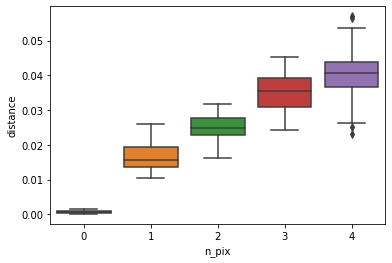

In [18]:
ax = sns.boxplot(x='n_pix', y='distance', data=test_history)
plt.savefig('test_history.png')

In [19]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

test_history = test_history.set_index(['n_pix'])
test_history['distance'].groupby(test_history.index).agg(["mean", "median", "std", "min", "max", percentile(25), percentile(50), percentile(75)])

,mean,median,std,min,max,percentile_25,percentile_50,percentile_75
n_pix,,,,,,,,
0,0.000682,0.000677,0.000349,0.000107,0.001622,0.000410,0.000677,0.000915
1,0.016340,0.015623,0.003528,0.010420,0.025883,0.013525,0.015623,0.019270
2,0.024972,0.024817,0.003313,0.016188,0.031853,0.022794,0.024817,0.027642
3,0.035427,0.035361,0.005462,0.024208,0.045333,0.030867,0.035361,0.039371
4,0.040056,0.040675,0.007220,0.023030,0.056988,0.036594,0.040675,0.043795


# Pixel Deviation to Euclidean Distance

In [20]:
# File of 3D pose annotations of the ApolloCar3D dataset
df = pd.read_csv('../input/pku-autonomous-driving/train.csv') # download at https://www.kaggle.com/competitions/pku-autonomous-driving/data?select=train.csv

In [21]:
from math import sin, cos

h_out, w_out = H, W
camera_matrix = CAMERA
camera_matrix_inv = np.linalg.inv(camera_matrix)

def str2coords(s, names=['id', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def get_img_coords(s, trans_x=0., trans_y=0.):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    world_mat = np.eye(4)
    
    trans = np.array([trans_x, trans_y, 0.0])
    
    world_mat[:3, 3]  = trans
    world_mat[:3, :3] = np.array([[1.0, 0.0, 0.0], 
                              [0.0, 1.0, 0.0], 
                              [0.0, 0.0, 1.0]]).T
    world_mat = world_mat[:3, :]
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    
    hs = [1.0 for c in coords]
    P = np.array(list(zip(xs, ys, zs, hs))).T

    img_p = np.dot(camera_matrix, np.dot(world_mat, P)).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_cs = img_p[:, 0]
    img_rs = img_p[:, 1]
    
    img_zs = img_p[:, 2] # z = Distance from the camera
    
    return img_rs, img_cs, img_zs, coords

def _regr_preprocess(regr_dict, is_flip=False):
    regr_dict_co = dict()
    regr_dict_ag = dict()
    for name in ['x', 'y', 'z']:
        regr_dict_co[name] = regr_dict[name]
    regr_dict_ag['roll'] = regr_dict['roll']
    regr_dict_ag['pitch'] = regr_dict['pitch']
    regr_dict_ag['yaw'] = regr_dict['yaw']
    
    return regr_dict_co, regr_dict_ag

# https://www.kaggle.com/diegojohnson/centernet-objects-as-points
def get_heatmap(p_x, p_y, sigma=3.):
    X1 = np.linspace(1, w_out, w_out)
    Y1 = np.linspace(1, h_out, h_out)
    [X, Y] = np.meshgrid(X1, Y1)
    X = (X - p_x)*2.
    Y = (Y - p_y)*2.
    D2 = X * X + Y * Y
    E2 = sigma
    heatmap = np.exp(-np.sqrt(D2) / E2)
    return heatmap

def get_mask_and_regr(labels, is_heatmap=True):
    regr_names = ['x', 'y', 'z', 'pitch', 'yaw', 'roll']
    mask = np.zeros([h_out, w_out, 1], dtype='float16')
    bin_mask = np.zeros([h_out, w_out, 3], dtype='float16')
    regr_co_soft = np.zeros([h_out, w_out, 3], dtype='float16')
    regr_z = np.ones([h_out, w_out], dtype='float16') * INF
    if labels is not None:
        rs, cs, zs, coords = get_img_coords(labels)
    
        for r, c, z, regr_dict in zip(rs, cs, zs, coords):
            r = (r) * (h_out*2) / IMG_SHAPE[0] - h_out
            r = (r).astype('int')
            c = (c) * w_out / IMG_SHAPE[1]
            c = (c).astype('int')

            if (r >= 0) and (r < h_out) and (c >= 0) and (c < w_out):
                regr_dict_co, _ = _regr_preprocess(regr_dict, is_flip=False)
                regr_co_soft[r, c] = [regr_dict_co[n] for n in sorted(regr_dict_co)]

                if is_heatmap:
                    heatmap = get_heatmap(c, r)
                    mask[:,:,0] = np.maximum(mask[:,:,0],heatmap[:,:])
                    rows, cols = np.where(heatmap > 0.25)

                    for r0, c0 in zip(rows, cols):
                        if z < regr_z[r0, c0]:
                            regr_z[r0, c0] = z
                            regr_co_soft[r0, c0] = regr_co_soft[r, c]
                            bin_mask[r0,c0,:] = 1.
                else:
                    bin_mask[r, c,:] = 1.

    return mask, bin_mask, regr_co_soft

class DistanceDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, sample_indices=None, n_pix=0):
        self.df = dataframe
        self.sample_indices = sample_indices
        self.n_pix = n_pix

    def __len__(self):
        if self.sample_indices is not None:
            return len(self.sample_indices)
        return N_CONFIGURATIONS

    def __getitem__(self, idx):
        if self.sample_indices is not None:
            idx = self.sample_indices[idx]
            
        # Get image name
        im_code, labels = self.df.iloc[idx]
        # PART 2
        
        mask_soft_, bin_mask_, regr_co_soft_ = get_mask_and_regr(labels)
        mask_soft_ = np.rollaxis(mask_soft_, 2, 0)
        mask_soft = torch.from_numpy(mask_soft_).float()
        del mask_soft_
        
        rs, cs = np.where(bin_mask_[:,:,0]>0.)
        ys = (rs+h_out+.5) * IMG_SHAPE[0] / (h_out*2)
        xs = (cs+.5) * IMG_SHAPE[1] / w_out
        sky_labels0 = np.concatenate([np.reshape(xs,[-1,1])*regr_co_soft_[rs,cs,-1:],np.reshape(ys,[-1,1])*regr_co_soft_[rs,cs,-1:],regr_co_soft_[rs,cs,-1:]],axis=1)
        sky_label0 = np.dot(camera_matrix_inv, sky_labels0.T).T
        sky_labels = np.concatenate((np.zeros_like(sky_label0[:,:1]), np.zeros_like(sky_label0), sky_label0),axis=1)
        sky_labels = np.reshape(sky_labels, [-1]).tolist()
        sky_labels = ' '.join([str(elem) for elem in sky_labels])
        
        
        offset_list = list(range(2*self.n_pix+1))
        # Probs: prepare a uniform distribution
        p_list = list(range(2*self.n_pix+1))
        p_sum = 0.
        for i in range(2*self.n_pix+1):
            offset_list[i] = offset_list[i]-self.n_pix
            p_list[i] = 1./(2*self.n_pix+1)
            p_sum = p_sum + p_list[i]
        p_list[-1] = 1.-(p_sum-p_list[-1])
        # end Probs
        
        # Noise: prepare screen positions of active points of new target representation
        target_np_x_offset = np.random.choice(offset_list, size=rs.shape, replace=True, p=p_list)
        target_np_y_offset = np.random.choice(offset_list, size=rs.shape, replace=True, p=p_list)
        
        rs = rs
        ys = (rs+target_np_y_offset+h_out+.5) * IMG_SHAPE[0] / (h_out*2)
        xs = (cs+target_np_x_offset+.5) * IMG_SHAPE[1] / w_out
        # end Noise
        
        sky_labels1 = np.concatenate([np.reshape(xs,[-1,1])*regr_co_soft_[rs,cs,-1:],np.reshape(ys,[-1,1])*regr_co_soft_[rs,cs,-1:],regr_co_soft_[rs,cs,-1:]],axis=1)
        sky_label1 = np.dot(camera_matrix_inv, sky_labels1.T).T

        distances = np.mean(np.sum((sky_label1 - sky_label0)**2, axis=1)**.5)
        
        return distances

In [22]:
dataset = DistanceDataset(df, train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0)
average_distance_table = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['n_pix']), columns=['Avg. Dist.'])

for i_n_pix in range(len(n_pix_list)):
    n_pix = n_pix_list[i_n_pix]
    dataset.n_pix=n_pix
    
    s_distance = 0.
    for batch_idx, distances in enumerate(tqdm(train_loader)):
        s_distance = s_distance+torch.mean(distances)
    
    avg_dist = (s_distance.numpy()/len(dataset))
    average_distance_table.loc[(n_pix), 'Avg. Dist.'] = avg_dist
    print(avg_dist)

  1%|          | 3/512 [00:00<00:18, 27.97it/s]

0.0


  1%|          | 3/512 [00:00<00:18, 27.19it/s]

0.28335473025083635


  1%|          | 4/512 [00:00<00:13, 36.44it/s]

0.4945563239067351


  1%|          | 4/512 [00:00<00:15, 32.41it/s]

0.6998185361591504


100%|██████████| 512/512 [00:17<00:00, 28.78it/s]

0.9047735615299922


In [23]:
average_distance_table

,Avg. Dist.
n_pix,
0,0.000000
1,0.283355
2,0.494556
3,0.699819
4,0.904774
